# Chapter 18

*Modeling and Simulation in Python*

Copyright 2021 Allen Downey

License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [1]:
# check if the libraries we need are installed

try:
    import pint
except ImportError:
    !pip install pint
    
try:
    import modsim
except ImportError:
    !pip install modsimpy

### Code from the previous chapter

Read the data.

In [2]:
import os

filename = 'glucose_insulin.csv'

if not os.path.exists(filename):
    !wget https://raw.githubusercontent.com/AllenDowney/ModSimPy/master/data/glucose_insulin.csv

In [3]:
from pandas import read_csv

data = read_csv(filename, index_col='time');

Interpolate the insulin data.

In [4]:
from modsim import interpolate

I = interpolate(data.insulin)

In this chapter, we implement the glucose minimal model described in the previous chapter. We'll start with `run_simulation`, which solves
differential equations using discrete time steps. This method works well enough for many applications, but it is not very accurate. In this chapter we explore a better option: using an **ODE solver**.

## Implementation

To get started, let's assume that the parameters of the model are known.
We'll implement the model and use it to generate time series for `G` and `X`. Then we'll see how to find the parameters that generate the series that best fits the data.

We can pass `params` and `data` to `make_system`:

In [5]:
from modsim import State, System

def make_system(params, data):
    G0, k1, k2, k3 = params
    
    Gb = data.glucose[0]
    Ib = data.insulin[0]
    I = interpolate(data.insulin)
    
    t_0 = data.index[0]
    t_end = data.index[-1]
    
    init = State(G=G0, X=0)
    
    return System(params=params, init=init, 
                  Gb=Gb, Ib=Ib, I=I,
                  t_0=t_0, t_end=t_end, dt=2)

`make_system` uses the measurements at `t=0` as the basal levels, `Gb`
and `Ib`. It gets `t_0` and `t_end` from the data. And it uses the
parameter `G0` as the initial value for `G`. Then it packs everything
into a `System` object.

Taking advantage of estimates from prior work, we'll start with these
values:

In [6]:
#        G0,  k1,   k2,   k3
params = 290, 0.03, 0.02, 1e-05
system = make_system(params, data)

Here's the update function:

In [7]:
def update_func(state, t, system):
    G, X = state
    G0, k1, k2, k3 = system.params 
    I, Ib, Gb = system.I, system.Ib, system.Gb
    dt = system.dt
        
    dGdt = -k1 * (G - Gb) - X*G
    dXdt = k3 * (I(t) - Ib) - k2 * X
    
    G += dGdt * dt
    X += dXdt * dt

    return State(G=G, X=X)

As usual, the update function takes a `State` object, a time, and a
`System` object as parameters. The first line uses multiple assignment
to extract the current values of `G` and `X`.

The following lines unpack the parameters we need from the `System`
object.

Computing the derivatives `dGdt` and `dXdt` is straightforward; we just
translate the equations from math notation to Python.

Then, to perform the update, we multiply each derivative by the discrete
time step `dt`, which is 2 min in this example. The return value is a
`State` object with the new values of `G` and `X`.

Before running the simulation, it is a good idea to run the update
function with the initial conditions:

In [8]:
update_func(system.init, system.t_0, system)

G    278.12
X      0.00
dtype: float64

If it runs without errors and there is nothing obviously wrong with the
results, we are ready to run the simulation. We'll use this version of
`run_simulation`, which is very similar to previous versions:

In [9]:
from modsim import linrange, TimeFrame

def run_simulation(system, update_func):
    init = system.init
    t_0, t_end, dt = system.t_0, system.t_end, system.dt
    
    t_array = linrange(system.t_0, system.t_end, system.dt)
    n = len(t_array)
    
    frame = TimeFrame(index=t_array, columns=init.index)
    frame.iloc[0] = system.init
    
    for i in range(n-1):
        t = t_array[i]
        state = frame.iloc[i]
        frame.iloc[i+1] = update_func(state, t, system)
    
    return frame

We can run it like this:

In [10]:
results = run_simulation(system, update_func)
results.head()

,G,X
0.0,290,0
2.0,278.12,0.0
4.0,266.9528,0.0003
6.0,256.29546,0.002668
8.0,245.07014,0.004041


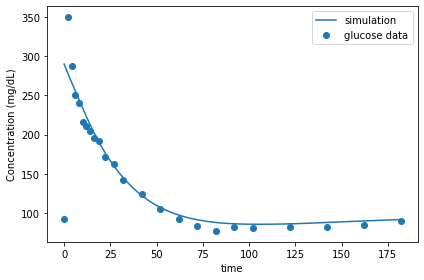

In [11]:
from modsim import decorate

results.G.plot(style='-', label='simulation')
data.glucose.plot(style='o', color='C0', label='glucose data')
decorate(ylabel='Concentration (mg/dL)')

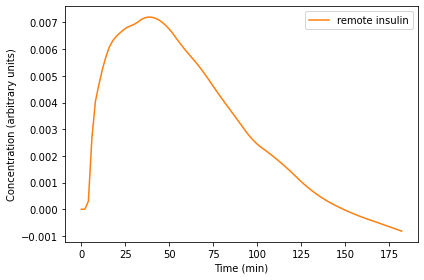

In [12]:
results.X.plot(color='C1', label='remote insulin')

decorate(xlabel='Time (min)', 
         ylabel='Concentration (arbitrary units)')

 shows the results. The top plot shows
simulated glucose levels from the model along with the measured data.
The bottom plot shows simulated insulin levels in tissue fluid, which is in unspecified units, and not to be confused with measured insulin
levels in the blood.

With the parameters I chose, the model fits the data well, except for
the first few data points, where we don't expect the model to be
accurate.

## Solving differential equations

So far we have solved differential equations by rewriting them as
difference equations. In the current example, the differential equations are: 

$$\frac{dG}{dt} = -k_1 \left[ G(t) - G_b \right] - X(t) G(t)$$

$$\frac{dX}{dt} = k_3 \left[I(t) - I_b \right] - k_2 X(t)$$ 

If we multiply both sides by $dt$, we have:

$$dG = \left[ -k_1 \left[ G(t) - G_b \right] - X(t) G(t) \right] dt$$

$$dX = \left[ k_3 \left[I(t) - I_b \right] - k_2 X(t) \right] dt$$ 

When $dt$ is very small, or more precisely **infinitesimal**, this equation is exact. But in our simulations, $dt$ is 2 min, which is not very small. In effect, the simulations assume that the derivatives $dG/dt$ and $dX/dt$ are constant during each 2 min time step.

This method, evaluating derivatives at discrete time steps and assuming that they are constant in between, is called **Euler's method** (see <http://modsimpy.com/euler>).

Euler's method is good enough for some simple problems, but it is not
very accurate. Other methods are more accurate, but many of them are
substantially more complicated.

One of the best simple methods is called **Ralston's method**. The
ModSim library provides a function called `run_ode_solver` that
implements it.

The "ODE" in `run_ode_solver` stands for "ordinary differential
equation". The equations we are solving are "ordinary" because all the
derivatives are with respect to the same variable; in other words, there are no partial derivatives.

To use `run_ode_solver`, we have to provide a "slope function", like
this:

In [13]:
def slope_func(t, state, system):
    G, X = state
    G0, k1, k2, k3 = system.params 
    I, Ib, Gb = system.I, system.Ib, system.Gb
        
    dGdt = -k1 * (G - Gb) - X*G
    dXdt = k3 * (I(t) - Ib) - k2 * X
    
    return dGdt, dXdt

`slope_func` is similar to `update_func`; in fact, it takes the same
parameters in the same order. But `slope_func` is simpler, because all
we have to do is compute the derivatives, that is, the slopes. We don't
have to do the updates; `run_ode_solver` does them for us.

Now we can call `run_ode_solver` like this:

In [14]:
from modsim import run_solve_ivp

In [15]:
results2, details = run_solve_ivp(system, slope_func)
details

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 86
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
 t_events: None
 y_events: None

`run_ode_solver` is similar to `run_simulation`: it takes a `System`
object and a slope function as parameters. It returns two values: a
`TimeFrame` with the solution and a `ModSimSeries` with additional
information.

A `ModSimSeries` is like a `System` or `State` object; it contains a set
of variables and their values. The `ModSimSeries` from `run_ode_solver`,
which we assign to `details`, contains information about how the solver
ran, including a success code and diagnostic message.

The `TimeFrame`, which we assign to `results`, has one row for each time
step and one column for each state variable. In this example, the rows
are time from 0 to 182 minutes; the columns are the state variables, `G`
and `X`.

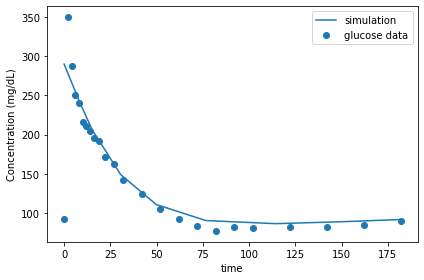

In [16]:
from modsim import decorate

results2.G.plot(style='-', label='simulation')
data.glucose.plot(style='o', color='C0', label='glucose data')
decorate(ylabel='Concentration (mg/dL)')

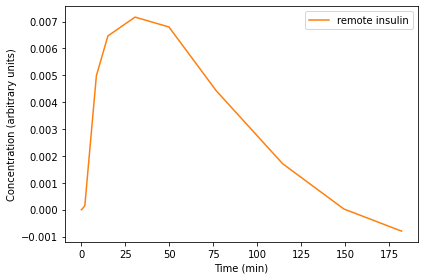

In [17]:
results2.X.plot(color='C1', label='remote insulin')

decorate(xlabel='Time (min)', 
         ylabel='Concentration (arbitrary units)')

shows the results from `run_simulation` and
`run_ode_solver`. The difference between them is barely visible.

We can compute the percentage differences like this:

In [18]:
diff = results.G - results2.G
percent_diff = diff / results2.G * 100
percent_diff.abs().max()

0.004442701427073649

The largest percentage difference is less than 2%, which is small enough that it probably doesn't matter in practice. 

## Summary

You might be interested in this article about [people making a DIY artificial pancreas](https://www.bloomberg.com/news/features/2018-08-08/the-250-biohack-that-s-revolutionizing-life-with-diabetes).

## Exercises

**Exercise:**  Our solution to the differential equations is only approximate because we used a finite step size, `dt=2` minutes.

If we make the step size smaller, we expect the solution to be more accurate.  Run the simulation with `dt=1` and compare the results.  What is the largest relative error between the two solutions?

In [19]:
# Solution

system.dt = 1
results3, details = run_simulation(system, slope_func)
details

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 86
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
 t_events: None
 y_events: None

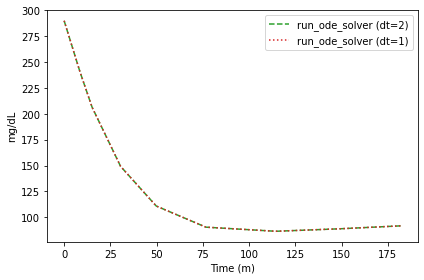

In [20]:
# Solution

results2.G.plot(style='C2--', label='run_ode_solver (dt=2)')
results3.G.plot(style='C3:', label='run_ode_solver (dt=1)')

decorate(xlabel='Time (m)', ylabel='mg/dL')

In [21]:
# Solution

diff = (results2.G - results3.G).dropna()
percent_diff = diff / results2.G * 100

In [22]:
# Solution

max(abs(percent_diff))

0.0

## Under the hood

Here's the source code for `run_solve_ivp` if you'd like to know how it works.

[RK45](https://en.wikipedia.org/wiki/List_of_Runge–Kutta_methods).